# Práctico 11: Navegación

La corteza entorrinal está ubicada en el lóbulo temporal medio. Es una estructura clave en el sistema de memoria y navegación espacial, ya que actúa como una interfaz entre el hipocampo y otras áreas corticales. Codifica información espacial y memoria episódica. Muchas de las neuronas de la capa II de la corteza entorrinal de las ratas son células grilla (o células de red). [Las celulas grilla son cruciales para la representación interna del espacio y la orientación de la rata](https://www.youtube.com/watch?v=8QJXDYQ4WiA).

En este práctico, vamos a implementar un modelo computacional que intenta explicar mejor los mecanismos por los cuales emergen estos comportamientos.

## Configuración

Para ello, sólamente vamos a utilizar dos librerías, Numnpy y Matplotlib, por lo que procedemos a importarlas:

In [1]:
import io, requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

### Constantes

In [2]:
# Salto temporal, en segundos
dt = .02

# Duración total de la simulación, en segundos
tmax = 200

# Periodo de tiempo que queremos observar
t = np.arange(0, tmax, dt)

# Scaling factor relating speed to oscillator frequencies, en Hz/(m/s)
beta = 0.385

# Umbral de disparo
spike_threshold = 1.8

# Bines en que se separará el espacio, tanto en el eje x como en el eje y
n_spatial_bins = 60

# Variable donde guardaremos registros para evitar descargarlos múltiples veces
_cached_recordings = None

### Funciones utilitarias

In [3]:
def integrar_trayectoria(x0, y0, vels):
    # Velocidad, en m/s
    velocidades = np.array([])
    
    # Dirección, en radianos
    direcciones = np.array([])
    
    # Posición, en metros
    x = np.array([x0])
    y = np.array([y0])
    
    for i in range(1, len(t)):
        v = vels[:, i]
        direcciones = np.append(direcciones, np.arctan2(v[1], v[0]))
        velocidades = np.append(velocidades, np.sqrt(np.square(v[0]) + np.square(v[1])))
        x = np.append(x, x[-1] + v[0] * dt)
        y = np.append(y, y[-1] + v[1] * dt)

    velocidades = np.insert(velocidades, 0, velocidades[0])
    direcciones = np.insert(direcciones, 0, direcciones[0])

    posiciones = np.array(list(zip(x, y)))
    
    return posiciones, velocidades, direcciones

def generar_trayectoria(t, theta=0.0):
    tmax = t[-1] - t[0]

    d = np.array([np.cos(theta), np.sin(theta)], dtype=float)

    # Caja de límites
    xmin, xmax = -0.9, 0.9
    ymin, ymax = -0.9, 0.9

    # Distancias desde el centro (0,0) hasta los bordes en la dirección d
    # Usamos np.inf cuando la componente es 0 para evitar división por cero.
    dist_xp = (xmax / d[0]) if d[0] > 0 else np.inf
    dist_xn = (xmin / d[0]) if d[0] < 0 else np.inf
    dist_yp = (ymax / d[1]) if d[1] > 0 else np.inf
    dist_yn = (ymin / d[1]) if d[1] < 0 else np.inf

    # Mitad de la longitud del segmento de intersección (desde el centro hasta un borde)
    L = min(
        [dist for dist in (dist_xp, dist_xn, dist_yp, dist_yn) if dist > 0],
        default=0.0
    )

    L *= 0.999

    # Velocidad tal que en tiempo T se recorre de -L a +L (es decir, 2L)
    speed = 2.0 * L / tmax

    # Vector velocidad constante
    vel = speed * d

    # Velocidad repetida para todos los instantes de tiempo
    vels = np.repeat(vel[:, None], len(t), axis=1)

    # Posición inicial: un extremo del segmento dentro del bounding box
    x0 = -L * d[0]
    y0 = -L * d[1]

    return integrar_trayectoria(x0, y0, vels)
    
def descargar_trayectoria():
    global _cached_recordings

    if _cached_recordings is None:
        url = 'https://raw.githubusercontent.com/MaestriaCienciasCognitivas/ncc/main/book/static/Practico11_HaftingTraj.npy'
        response = requests.get(url)
        response.raise_for_status()
    
        # Cargamos datos reales de navegación
        # Las primeras dos dimensiones se corresponden a los ejes x e y
        # La tercera dimension se corresponde al tiempo de cada medición
        _cached_recordings = np.load(io.BytesIO(response.content))

    recordings = _cached_recordings
    
    # Obtenemos las posiciones, ajustadas para que la matriz tenga nuestro salto temporal dt
    time_steps = np.arange(0, recordings[2][-1], dt)
    pos = np.array([
        np.interp(time_steps, recordings[2], recordings[0]),
        np.interp(time_steps, recordings[2], recordings[1])
    ])

    # Pasamos de cm a m
    pos = pos / 100
    
    # Velocidad variable, en m/s
    vels = np.array([np.diff(pos[0, :]), np.diff(pos[1, :])]) / dt

    # Posición inicial, en m
    x0 = pos[0][0]
    y0 = pos[1][0]

    return integrar_trayectoria(x0, y0, vels)

### Funciones de graficado

In [4]:
def visualizar_trayectoria(posiciones, velocidades, direcciones):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    ax1.scatter(posiciones[:,0], posiciones[:,1])
    ax1.set_title("Posiciones", fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)

    ax2.plot(t, velocidades)
    ax2.set_title("Velocidades", fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=8)

    ax3.plot(t, direcciones)
    ax3.set_title("Direcciones", fontsize=10)
    ax3.tick_params(axis='both', which='major', labelsize=8)
    
    plt.show()
    
def visualizar_modelo(posiciones, f, spikes, occupancy, spike_x, spike_y, spike_phases):
    cmap = plt.get_cmap('jet')
    cmap = cmap.resampled(64)
    cmap = matplotlib.colors.ListedColormap([cmap(x) for x in range(32, 64)] + [cmap(x) for x in range(32)])
    
    phaseInds = np.mod(spike_phases, 2 * np.pi) * (cmap.N - 1) / (2 * np.pi)
    pointColors = cmap(np.ceil(phaseInds).astype(int))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
        
    ax1.plot(t, f)
    ax1.axhline(y=spike_threshold, color='r', linestyle='-')
    ax1.set_xlabel("Tiempo (s)", fontsize=9)
    ax1.set_title("Actividad (azul) y umbral (rojo)", fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=8)

    ax2.imshow(np.divide(spikes, np.where(occupancy != 0, occupancy, np.nan)), origin='lower')
    ax2.set_facecolor("black")
    ax2.set_title(f"Mapa de frecuencias\nt = {tmax}s", fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=8)
    
    ax3.scatter(spike_x, spike_y, 30 * np.ones(len(spike_x)), c=pointColors, alpha=1)
    ax3.plot(posiciones[:, 0], posiciones[:, 1], zorder=0)
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)
    ax3.set_title("Trayectoria (azul) y\ndisparos (coloreados por fase theta)", fontsize=10)
    ax3.tick_params(axis='both', which='major', labelsize=8)

    plt.plot()

## Trayectorias

Para simular un modelo de navegación es fundamental contar primero con una trayectoria. La función `descargar_trayectoria` descarga datos recogidos por Hafting y colaboradores (2005) a partir de colocar ratas en cajas circulares de diferentes tamaños. Estos datos en particular provienen de colocarlas en cajas de 90 cm de diámetro. 

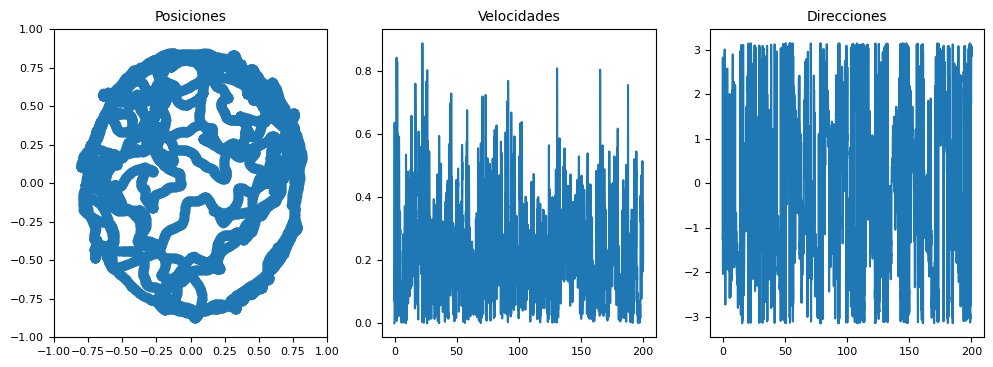

In [5]:
posiciones, velocidades, direcciones = descargar_trayectoria()
visualizar_trayectoria(posiciones, velocidades, direcciones)

También es fundamental poder generar trayectorias artificiales para poner a prueba el modelo en forma controlada. Esto es la gran ventaja de contar con modelos computacionales, podemos visualizar cómo se comporta el modelo con datos que no vemos en el laboratorio. Te dejamos una función llamada `generar_trayectoria` que genera trayectorias artificiales en una caja imaginaria de 90x90 cm.

Probá diferentes valores para `theta` para tener una idea de las trayectorias que podrás simular. ¿Que es `theta` y en qué unidades está?

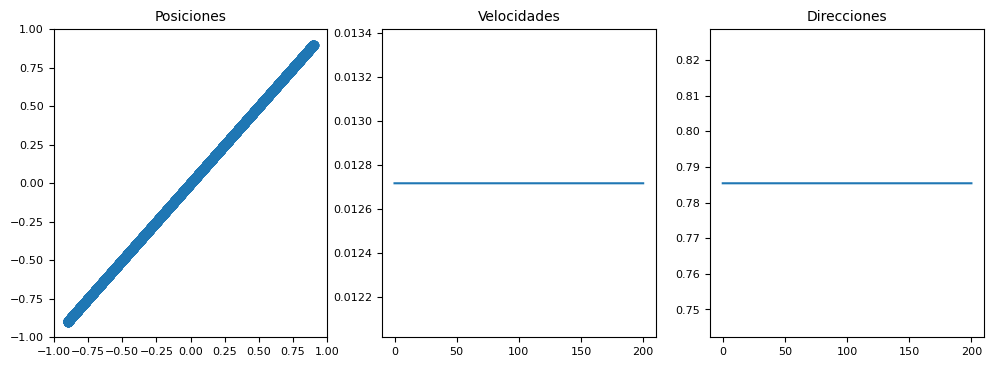

In [6]:
posiciones, velocidades, direcciones = generar_trayectoria(t, theta=np.pi / 4)
visualizar_trayectoria(posiciones, velocidades, direcciones)

Si prestaste atención, habrás notado que las dos funciones devuelven tres variables: `posiciones`, `velocidades` y `direcciones`. Investiga qué nos están informando y en qué unidades de medida. Esto es importante porque el modelo computacional que veremos más adelante usa esta información para simular actividades neuronales.

## Simulación

A continuación, definimos una función que calcula la actividad producida por el modelo computacional a partir de la velocidad y orientación del movimiento en cada ventana temporal.

El resultado de la funcion será:

- `f`: Un vector con las activaciones del modelo en cada paso de la integración.
- `spikes`: Una matriz con la cantidad de activaciones que se registraron en cada bin del espacio.
- `occupancy`: Una matriz con la cantidad de veces que se registró movimiento en cada bin del espacio.
- `spike_x`: Un vector con las coordenadas en el eje x en cada activación por encima del umbral.
- `spike_y`: Un vector con las coordenadas en el eje x en cada activación por encima del umbral.
- `spike_phases`: Un vector con las fases del oscilador en cada activación por encima del umbral.

In [7]:
# Basline maintains a fixed frequency, dorsal, en Hz
# Directional preference of each dendrite (this also sets the number of dendrites)
def integrar_modelo(posiciones, velocidades, direcciones, base_freq = 6.42, dir_preferences = np.array([0, 2*np.pi/3, 4*np.pi/3])):
    # Oscillators will start at phase 0, en radianes
    dendrite_phases = np.array(np.zeros((1, len(dir_preferences))))
    base_phase = np.array([0])
    
    # Firing field plot variables
    min_x = -0.9
    max_x = 0.9
    min_y = -0.9
    max_y = 0.9
    
    occupancy = np.zeros((n_spatial_bins, n_spatial_bins))
    spikes = np.zeros((n_spatial_bins, n_spatial_bins))
    
    f = np.array([0])
    
    spike_times = np.array([])
    spike_x = np.array([])
    spike_y = np.array([])
    spike_phases = np.array([])
    
    for i in range(0, len(posiciones)-1):
        x, y = posiciones[i]
        velocidad = velocidades[i]
        direccion = direcciones[i]
        
        # Dendrite frequencies are pushed up or down from the basline frequency
        # depending on the speed and head direction, with a scaling factor
        # baseFreq*beta that sets the spacing between the spatial grid fields.
        # en Hz
        dendrite_freqs = base_freq + base_freq * beta * velocidad * np.cos(direccion - dir_preferences)
    
        # Advance oscillator phases
        # Radial frequency (2pi times frequency in Hz) is the time derivative of phase.
        # En rad
        dendrite_phases = np.vstack((dendrite_phases, dendrite_phases[-1] + dt * 2 * np.pi * dendrite_freqs))
        base_phase = np.append(base_phase, base_phase[-1] + dt * 2 * np.pi * base_freq)
    
        # Sum each dendritic oscillation separately with the baseline oscillation
        dendrite_plus_baseline = np.cos(dendrite_phases[-1]) + np.cos(base_phase[-1])
    
        # Final activity is the product of the oscillations.
        # Note this rule has some odd features such as positive
        # activity given an even number of negative oscillator sums and
        # the baseline is included separately in each term in the product.
        f = np.append(f, np.maximum(np.prod(dendrite_plus_baseline), 0))
        
        if f[-1] > spike_threshold:
            spike_times = np.append(spike_times, t[i])
            spike_x = np.append(spike_x, x)
            spike_y = np.append(spike_y, y)
            spike_phases = np.append(spike_phases, base_phase[-1])

        xindex = np.clip(int(np.round((x-min_x)/(max_x-min_x)*n_spatial_bins)), 0, n_spatial_bins-1)
        yindex = np.clip(int(np.round((y-min_y)/(max_y-min_y)*n_spatial_bins)), 0, n_spatial_bins-1)
        
        occupancy[yindex][xindex] = occupancy[yindex][xindex] + dt
        if f[-1] > spike_threshold:
           spikes[yindex][xindex] = spikes[yindex][xindex] + 1

    return f, spikes, occupancy, spike_x, spike_y, spike_phases

Ahora sí, podemos ver como se comporta el modelo según diferentes configuraciones. Primero fijate cómo se comporta en una trayectoria real. Detenete a pensar qué esta graficando cada una de las gráficas (podés usar los artículos que compartimos).

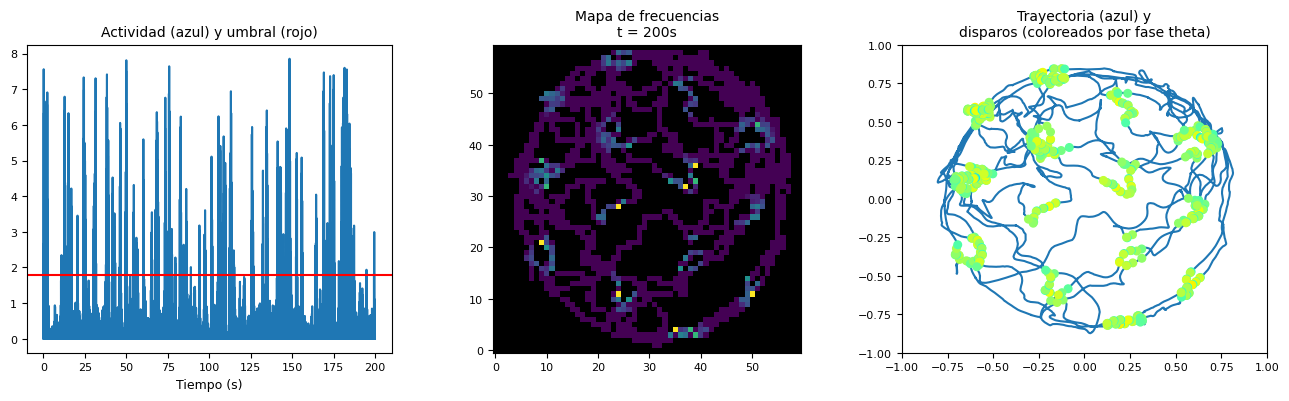

In [8]:
base_freq = 6.42
dir_preferences = np.array([0, 2*np.pi/3, 4*np.pi/3])

# Usá esta línea para descargar una trayectoria medida en el laboratorio
posiciones, velocidades, direcciones = descargar_trayectoria()

f, spikes, occupancy, spike_x, spike_y, spike_phases = integrar_modelo(posiciones, velocidades, direcciones, base_freq, dir_preferences)
visualizar_modelo(posiciones, f, spikes, occupancy, spike_x, spike_y, spike_phases)

¿Qué pasa si cambiás `base_freq` y `dir_preferences`? ¿Por qué son importantes en el modelo?

Poné a prueba tus hipótesis con trayectorias artificiales usando la celda siguiente.

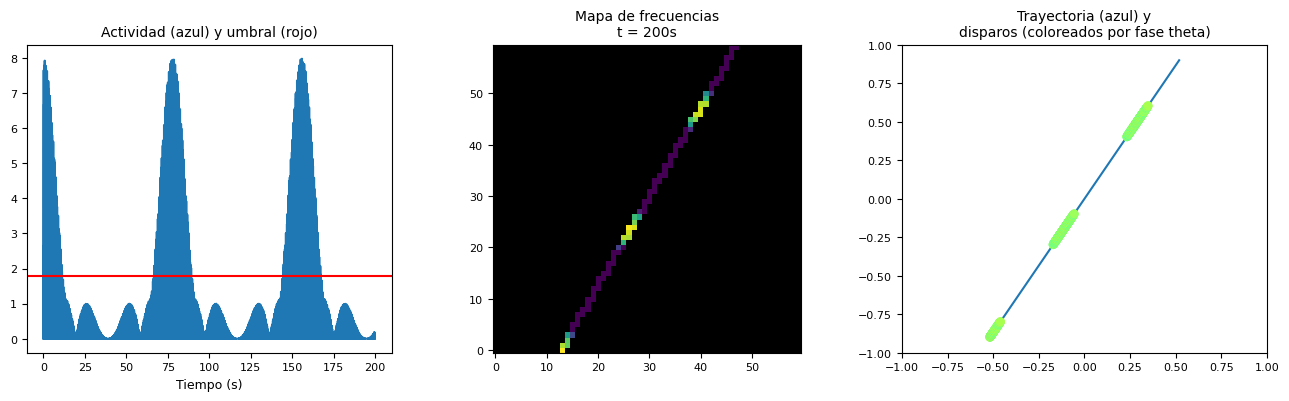

In [9]:
base_freq = 6.42
dir_preferences = np.array([0, 2*np.pi/3, 4*np.pi/3])

posiciones, velocidades, direcciones = generar_trayectoria(t, np.pi / 3)

f, spikes, occupancy, spike_x, spike_y, spike_phases = integrar_modelo(posiciones, velocidades, direcciones, base_freq, dir_preferences)
visualizar_modelo(posiciones, f, spikes, occupancy, spike_x, spike_y, spike_phases)

## Referencias

Giocomo,  L. M., Zilli, E. A., Fransen, E. & Hasselmo, M. E. (2007). Temporal Frequency of Subthreshold Oscillations Scales with Entorhinal Grid Cell Field Spacing. _Science_, 315, 1719-1722. [doi:10.1126/science.1139207](https://doi.org/10.1126/science.1139207).

Hafting, T., Fyhn, M., Molden, S., Moser, M. B. & Moser, E. I. (2005). Microstructure of a spatial map in the entorhinal cortex. _Nature_, 436, 801–806. [doi:10.1038/nature03721](https://doi.org/10.1038/nature03721).